# Identifying drug targets in *Staphylococcus aureus* using a GSMM

## Getting the model

First we start by loading the model for *S. aureus*, taken from the BiGG database in .xml file format, using the function **read_sbml_model()** from module COBRApy.

In [1]:
from cobra.io import read_sbml_model # function to read metabolic models in xml format

model = read_sbml_model('iYS854.xml')

Then we change our model's objective function as recommended in the original research article (check report for more information), and finally show the model summary.

In [2]:
model.objective = 'BIOMASS_iYS_reduced'
model.reactions.get_by_id('BIOMASS_iYS_reduced').upper_bound = 1000

model.summary()


Metabolite,Reaction,Flux,C-Number,C-Flux
cl_e,EX_cl_e,0.009622,0,0.00%
cys__L_e,EX_cys__L_e,0.3179,3,1.56%
fe2_e,EX_fe2_e,0.01381,0,0.00%
fe3_e,EX_fe3_e,0.01443,0,0.00%
glc__D_e,EX_glc__D_e,10,6,98.42%
h_e,EX_h_e,10,0,0.00%
k_e,EX_k_e,0.3608,0,0.00%
mg2_e,EX_mg2_e,0.01604,0,0.00%
mn2_e,EX_mn2_e,0.001278,0,0.00%
na1_e,EX_na1_e,3.866,0,0.00%


# Model Metrics

We can start off by identifying the scale of the model by printing some of its metrics.

In [3]:
print('Number of genes:', len(model.genes))
print('Number of metabolites:', len(model.metabolites))
print('Number of reactions:', len(model.reactions))


Number of genes: 866
Number of metabolites: 1335
Number of reactions: 1455


# Testing the Model using simulations

To gauge the accuracy of the model we used COBRApy's **.optimize()** method to run a few simulations in different mediums to then compare the effects on the biomass yield to the literature.

The different mediums tested were:

1) Aerobic + Glucose C-source;

2) Aerobic + Manose C-source;

3) Aerobic + Trehalose C-source;

4) Aerobic + Sorbitol C-source;

5) Anaerobic + Glucose C-source;

6) Anaerobic + Nitrate + Glucose C-source;

In [4]:
with model as aerobic_model:
    simul_aerobic = aerobic_model.optimize()
    print(f"{'Growth Value using Glucose:':<47}{round(simul_aerobic.objective_value, 4):>7}\t+++")

with model as manose_model:
    manose_medium = manose_model.medium
    manose_medium['EX_glc__D_e'] = 0.00
    manose_medium['EX_man_e'] = 10.0
    manose_model.medium = manose_medium 

    simul_manose = manose_model.optimize()
    print(f"{'Growth Value using Manose:':<47}{round(simul_manose.objective_value, 4):>7}\t+++")

with model as trehalose_model:
    trehalose_medium = trehalose_model.medium
    trehalose_medium['EX_glc__D_e'] = 0.00
    trehalose_medium['EX_tre_e'] = 10.0
    trehalose_model.medium = trehalose_medium

    simul_trehalose = trehalose_model.optimize()
    print(f"{'Growth Value using Trehalose:':<47}{round(simul_trehalose.objective_value, 3):>7}\t+++++")

with model as sorbitol_model:
    sorbitol_medium = sorbitol_model.medium
    sorbitol_medium['EX_glc__D_e'] = 0.00
    sorbitol_medium['EX_sbt__D_e'] = 10.0
    sorbitol_model.medium = sorbitol_medium

    simul_sorbitol = sorbitol_model.optimize()
    print(f"{'Growth Value using Sorbitol:':<47}{round(abs(simul_sorbitol.objective_value), 3):>7}\t-")

with model as anaerobic_model:
    anaerobic = anaerobic_model.medium
    anaerobic['EX_o2_e'] = 0.00
    anaerobic_model.medium = anaerobic

    simul_anaerobic = anaerobic_model.optimize()
    print(f"{'Growth Value in Anaerobic conditions + Glucose:':<47}{round(simul_anaerobic.objective_value, 3):>7}\t+")

with model as nitrate_model:
    nitrate = nitrate_model.medium
    nitrate['EX_o2_e'] = 0.00
    nitrate['EX_no3_e'] = 20.0
    nitrate_model.medium = nitrate

    simul_nitrate = nitrate_model.optimize()
    print(f"{'Growth Value in Anaerobic conditions + Nitrate:':<47}{round(simul_nitrate.objective_value, 3):>7}\t++")


Growth Value using Glucose:                      1.943	+++
Growth Value using Manose:                       1.943	+++
Growth Value using Trehalose:                    2.789	+++++
Growth Value using Sorbitol:                       0.0	-
Growth Value in Anaerobic conditions + Glucose:  0.901	+
Growth Value in Anaerobic conditions + Nitrate:  1.779	++


# Identifying the essential genes in our model

An essential gene is a gene that is crucial for the survival of an organism.

In our metabolic model, it refers to a gene that, when knocked out, reduces the objective function (usually biomass growth) to zero.

For this we can use COBRApy's **.single_gene_deletion()** method to individually knockout each gene and each time calculate a new value for the objective function:

To better understand what is the output of using this method, we have a test run below.

In [5]:
from cobra.flux_analysis import single_gene_deletion

with model:
    deletion_results = single_gene_deletion(model)
    print('The output is of type:', type(deletion_results))
    display(deletion_results)

The output is of type: <class 'pandas.core.frame.DataFrame'>


,ids,growth,status
0,{USA300HOU_RS07280},1.943002e+00,optimal
1,{USA300HOU_RS10950},1.943002e+00,optimal
2,{USA300HOU_RS10420},1.943002e+00,optimal
3,{USA300HOU_RS11340},1.943002e+00,optimal
4,{USA300HOU_RS11960},1.943002e+00,optimal
...,...,...,...
861,{USA300HOU_RS04410},1.943002e+00,optimal
862,{USA300HOU_RS06800},1.943002e+00,optimal
863,{USA300HOU_RS11060},1.036496e-14,optimal
864,{USA300HOU_RS09385},5.631312e-30,optimal


As we can see, the output of a **single_gene_deletion()** is a pandas dataframe with 866 rows (one for each gene) and 3 columns: the gene ids, the value of the objective function (biomass growth) and the status of the model's medium.

Now we can apply this function to determine which genes are essential.

In [6]:

with model:
    deletion_results = single_gene_deletion(model)

count = 0
essential_genes_default = []
for i in range(len(deletion_results.index)):
    if deletion_results.at[i, 'growth'] < 0.0001 or deletion_results.at[i, 'status'] != 'optimal': # if there is no growth or the medium is not optimal the gene is essential
        count += 1
        essential_genes_default.append(deletion_results.at[i, 'ids'])
        
print('Essential genes found using default medium:', essential_genes_default)
print('Default medium essential gene count:', count)

with model:
    give_essential = model.medium

    give_essential['EX_arg__L_e'] = 10.0
    give_essential['EX_gly_e'] = 10.0
    give_essential['EX_leu__L_e'] = 10.0
    give_essential['EX_pro__L_e'] = 10.0
    give_essential['EX_val__L_e'] = 10.0

    model.medium = give_essential
    deletion_results = single_gene_deletion(model)

count = 0
essential_genes_provided = []
for i in range(len(deletion_results.index)):
    if deletion_results.at[i, 'growth'] < 0.0001 or deletion_results.at[i, 'status'] != 'optimal':
        count += 1
        essential_genes_provided.append(deletion_results.at[i, 'ids'])

print('Essential genes found using medium with essential aminoacids provided:', essential_genes_provided)
print('With essential aminoacids provided:', count)
    

Essential genes found using default medium: [{'USA300HOU_RS01890'}, {'USA300HOU_RS04530'}, {'USA300HOU_RS06950'}, {'USA300HOU_RS11090'}, {'USA300HOU_RS05755'}, {'USA300HOU_RS07100'}, {'USA300HOU_RS08520'}, {'USA300HOU_RS06965'}, {'USA300HOU_RS04880'}, {'USA300HOU_RS06975'}, {'USA300HOU_RS11500'}, {'USA300HOU_RS14040'}, {'USA300HOU_RS00045'}, {'USA300HOU_RS07115'}, {'USA300HOU_RS06985'}, {'USA300HOU_RS02450'}, {'USA300HOU_RS06175'}, {'USA300HOU_RS05320'}, {'USA300HOU_RS05395'}, {'USA300HOU_RS06195'}, {'USA300HOU_RS04580'}, {'USA300HOU_RS11670'}, {'USA300HOU_RS13115'}, {'USA300HOU_RS08160'}, {'USA300HOU_RS05330'}, {'USA300HOU_RS08835'}, {'USA300HOU_RS14075'}, {'USA300HOU_RS08840'}, {'USA300HOU_RS02910'}, {'USA300HOU_RS02070'}, {'USA300HOU_RS05690'}, {'USA300HOU_RS00960'}, {'USA300HOU_RS04190'}, {'USA300HOU_RS09400'}, {'USA300HOU_RS04765'}, {'USA300HOU_RS04940'}, {'USA300HOU_RS02990'}, {'USA300HOU_RS03860'}, {'USA300HOU_RS01900'}, {'USA300HOU_RS06785'}, {'USA300HOU_RS07105'}, {'USA300HOU_

Before moving on we must convert our gene ids so that they match the ones that will be found in the databases that will be later consulted automatically.

In [7]:
def convert_gene_name(essential_genes):
    ''' Receives a gene list and converts its gene locus identifiers to ones that are compatible with the used databases in the rest of the script.
    '''
    return list(map(lambda x: str(x).replace('USA300HOU', 'SA'), essential_genes))

def trim(essential_genes):
    ''' Auxiliary function to make the gene list more presentable.
    '''
    result = []
    for gene in essential_genes:
        result.append(gene[2:len(gene)-2])
    return result


In [8]:
essential_genes = trim(convert_gene_name(essential_genes_provided)) # we are using the list of essential genes identified using the medium with provided essential aas
print('List of essential genes:', essential_genes)
print('Number of essential genes:', len(essential_genes))

List of essential genes: ['SA_RS07100', 'SA_RS08520', 'SA_RS06965', 'SA_RS04880', 'SA_RS06975', 'SA_RS11500', 'SA_RS14040', 'SA_RS00045', 'SA_RS07115', 'SA_RS06985', 'SA_RS01890', 'SA_RS04530', 'SA_RS06950', 'SA_RS05755', 'SA_RS02450', 'SA_RS06175', 'SA_RS05320', 'SA_RS06195', 'SA_RS04580', 'SA_RS11670', 'SA_RS09400', 'SA_RS04940', 'SA_RS02990', 'SA_RS03860', 'SA_RS01900', 'SA_RS06785', 'SA_RS07105', 'SA_RS05040', 'SA_RS06925', 'SA_RS06960', 'SA_RS02970', 'SA_RS13120', 'SA_RS07495', 'SA_RS11455', 'SA_RS06355', 'SA_RS10325', 'SA_RS03230', 'SA_RS14520', 'SA_RS06750', 'SA_RS09495', 'SA_RS06085', 'SA_RS06145', 'SA_RS10315', 'SA_RS08185', 'SA_RS09795', 'SA_RS08675', 'SA_RS08105', 'SA_RS11185', 'SA_RS08845', 'SA_RS14530', 'SA_RS05715', 'SA_RS09225', 'SA_RS12640', 'SA_RS00060', 'SA_RS02065', 'SA_RS02635', 'SA_RS06830', 'SA_RS14540', 'SA_RS09015', 'SA_RS13115', 'SA_RS08160', 'SA_RS05330', 'SA_RS08835', 'SA_RS14075', 'SA_RS08840', 'SA_RS02910', 'SA_RS02070', 'SA_RS05690', 'SA_RS00085', 'SA_RS05

We can also save our list to a file (one gene per line).

In [9]:
def write_gene_list(gene_list, file_name):
    '''Receives a list of genes and writes it to a file.
    '''
    with open(file_name,'w') as output:
        for gene in gene_list:
            output.write(gene + '\n')

write_gene_list(essential_genes,'essential_gene_list.txt')

# Getting the nucleotide sequences of the genes and the protein sequences coded by those genes

To get our nucleotide and protein sequences, we can find them online at [Aureowiki](https://aureowiki.med.uni-greifswald.de/Main_Page), a repository of information regarding *S. aureus*.

We simply input the gene identifier and get the corresponding sequences. This can be done directly through python, using the urllib module.


In [10]:
from urllib.request import urlopen
import re

def get_sequences(gene):
    ''' Receives a gene locus identifier and returns the gene's nucleotide sequence and the protein sequence it codes for.
    '''
    try:
        sequence_page = urlopen(f"https://aureowiki.med.uni-greifswald.de/{gene}")
    except:
        return ('not_found','not_found')
    else:
        html = sequence_page.read().decode("utf-8")
        protein_sequence = re.findall("""(?<=<span class="protein_seq">)(.*)(?=</span>)""", html)
        unfiltered_seq = re.findall("""(?<=<div class="dnaseq">)(.*)(?=</div>)""", html)
        nucleotide_sequence = ''.join(filter(lambda x: x in {'A','T','C','G'}, unfiltered_seq[0]))
        if protein_sequence[0] == '': protein_sequence = ['not_found'] + protein_sequence[1:]
        elif nucleotide_sequence == '': nucleotide_sequence = 'not_found'
        return protein_sequence[0], nucleotide_sequence

def write_fasta(essential_genes):
    ''' Receives a list of essential genes and writes their nucleotide sequences and their protein sequences into respective files in FASTA format.
    '''
    nucleotide_gene_locuses_not_found = []
    protein_gene_locuses_not_found = []
    with open('nucleotide_sequences.fasta','w') as nseqs, open('protein_sequences.fasta','w') as pseqs:
        for gene in essential_genes:
            pseq, nseq = get_sequences(gene)
            if pseq == 'not_found':
                protein_gene_locuses_not_found.append(gene)
            else:          
                pseqs.write(f'>{gene}\n{pseq}\n')
            if nseq == 'not_found':
                nucleotide_gene_locuses_not_found.append(gene)
            else:
                nseqs.write(f'>{gene}\n{nseq}\n')
    return protein_gene_locuses_not_found, nucleotide_gene_locuses_not_found
    

Some genes are not found in the database. Others are found but have no corresponding protein sequence.

These are stored and shown to the user to see which ones will not be considered moving forward.

In [11]:
prot_gnf, nuc_gnf = write_fasta(essential_genes)

In [12]:
print('Genes whose protein sequence was not found in the database: ', prot_gnf)
print('Genes whose nucleotide sequence was not found in the database: ', nuc_gnf)

Genes whose protein sequence was not found in the database:  ['SA_RS09495', 'SA_RS06145', 'SA_RS14540', 'SA_RS09295', 'SA_RS02780', 'SA_RS07110', 'SA_RS02455', 'SA_RS11335', 'SA_RS02790']
Genes whose nucleotide sequence was not found in the database:  ['SA_RS06145', 'SA_RS07110']


As previously mentioned, some genes were not available in repository, so we used the rest of them as our list.

Going forward, this list of essential genes will be reffered to as potential drug targets.

# Filtering our potential drug targets list

We now have two lists of potential drug targets: one for proteins and one for genes.

We need to filter both of these lists, keeping only the proteins/genes which are not present/dont have homologous genes in humans, so that we don't harm the human organism when we knockout these genes or inactivate the proteins' activity.

To do this we can do a BLAST search against the human genome (in the case of the gene list) and the human proteome (in the case of the protein list).

In both cases, we want to keep the genes/proteins that have **no hits** in the human genome/proteome.


The parameters for the nucleotide BLAST were as follows (any parameter not shown was left at the default value):

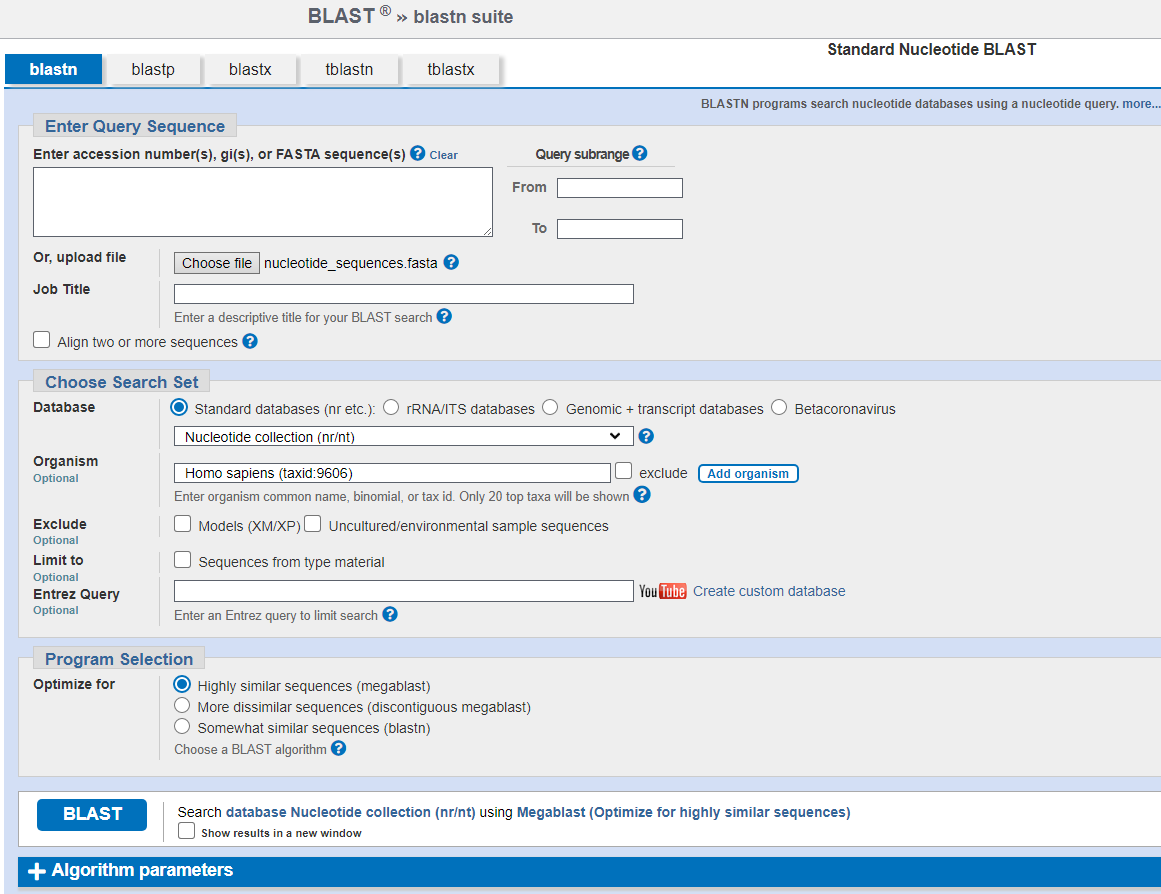

The parameters for the protein BLAST were as follows (any parameter not shown was left at the default value):

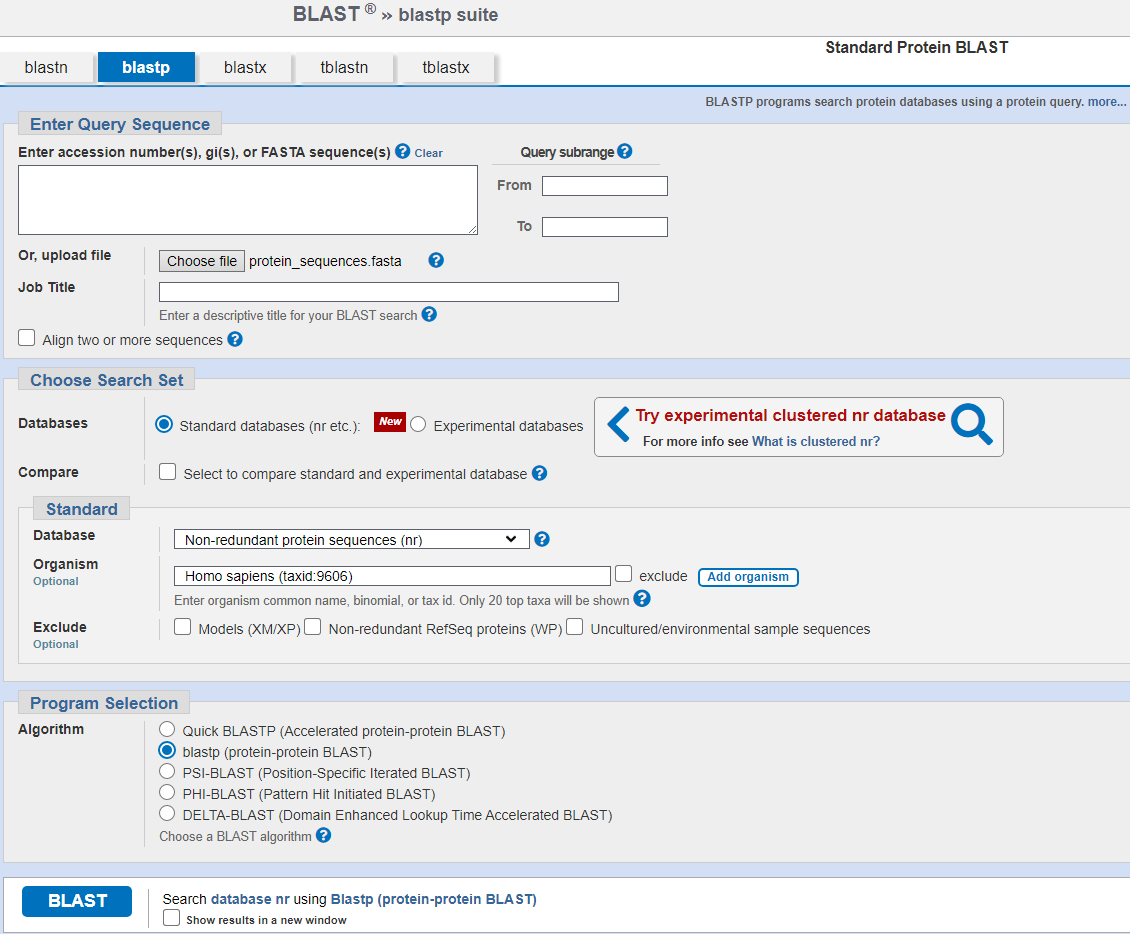

In [13]:
# Get the necessary imports
from Bio.Blast import NCBIXML 

In [14]:
# Get the BLAST results file, downloaded in XML format from NCBI BLAST website.
blastp_results = 'blastp_results_web.xml'
blastn_results = 'blastn_results_web.xml'

In [15]:
def filter_drug_targets(blast_results):
    ''' Receives an xml file of a blast search done on NCBI and returns a list of the genes/proteins that don't have homologues/aren't present in the human genome. 
    '''
    blast_records = NCBIXML.parse(open(blast_results, 'r'))
    filtered_drug_targets = []
    for blast_record in blast_records: 
        if blast_record.descriptions == []: # if the gene/protein got no hits in Homo sapiens
            filtered_drug_targets.append(blast_record.query) # get the gene name
    return filtered_drug_targets


In [16]:
protein_targets = filter_drug_targets(blastp_results)
gene_targets = filter_drug_targets(blastn_results)
write_gene_list(protein_targets,'protein_targets.txt')
write_gene_list(gene_targets,'gene_targets.txt')

# Our previous possible drug targets, without BLAST validation step
print('Previous possible drug targets: ', essential_genes)
print('Previous number of drug targets: ', len(essential_genes))

## Our newly updated possible drug targets after BLAST validation step
print('Filtered possible drug targets (based on genome): ', gene_targets)
print('Number of gene drug targets after filter: ', len(gene_targets))

## Our newly updated possible drug targets after BLAST validation step
print('Filtered possible drug targets (based on proteome): ', protein_targets)
print('Number of protein drug targets after filter: ', len(protein_targets))


Previous possible drug targets:  ['SA_RS07100', 'SA_RS08520', 'SA_RS06965', 'SA_RS04880', 'SA_RS06975', 'SA_RS11500', 'SA_RS14040', 'SA_RS00045', 'SA_RS07115', 'SA_RS06985', 'SA_RS01890', 'SA_RS04530', 'SA_RS06950', 'SA_RS05755', 'SA_RS02450', 'SA_RS06175', 'SA_RS05320', 'SA_RS06195', 'SA_RS04580', 'SA_RS11670', 'SA_RS09400', 'SA_RS04940', 'SA_RS02990', 'SA_RS03860', 'SA_RS01900', 'SA_RS06785', 'SA_RS07105', 'SA_RS05040', 'SA_RS06925', 'SA_RS06960', 'SA_RS02970', 'SA_RS13120', 'SA_RS07495', 'SA_RS11455', 'SA_RS06355', 'SA_RS10325', 'SA_RS03230', 'SA_RS14520', 'SA_RS06750', 'SA_RS09495', 'SA_RS06085', 'SA_RS06145', 'SA_RS10315', 'SA_RS08185', 'SA_RS09795', 'SA_RS08675', 'SA_RS08105', 'SA_RS11185', 'SA_RS08845', 'SA_RS14530', 'SA_RS05715', 'SA_RS09225', 'SA_RS12640', 'SA_RS00060', 'SA_RS02065', 'SA_RS02635', 'SA_RS06830', 'SA_RS14540', 'SA_RS09015', 'SA_RS13115', 'SA_RS08160', 'SA_RS05330', 'SA_RS08835', 'SA_RS14075', 'SA_RS08840', 'SA_RS02910', 'SA_RS02070', 'SA_RS05690', 'SA_RS00085', 

In [17]:
# Get only the genes that are common to both lists of potential drug targets
drug_targets = [x for x in protein_targets if x in gene_targets]
print(drug_targets)
print(len(drug_targets))

['SA_RS07100', 'SA_RS06965', 'SA_RS04880', 'SA_RS06975', 'SA_RS11500', 'SA_RS14040', 'SA_RS00045', 'SA_RS07115', 'SA_RS06985', 'SA_RS01890', 'SA_RS06950', 'SA_RS05755', 'SA_RS05320', 'SA_RS09400', 'SA_RS04940', 'SA_RS03860', 'SA_RS01900', 'SA_RS06785', 'SA_RS06925', 'SA_RS06960', 'SA_RS13120', 'SA_RS07495', 'SA_RS06355', 'SA_RS10325', 'SA_RS03230', 'SA_RS14520', 'SA_RS10315', 'SA_RS08185', 'SA_RS09795', 'SA_RS08105', 'SA_RS08845', 'SA_RS14530', 'SA_RS05715', 'SA_RS09225', 'SA_RS12640', 'SA_RS00060', 'SA_RS02065', 'SA_RS02635', 'SA_RS06830', 'SA_RS09015', 'SA_RS13115', 'SA_RS05330', 'SA_RS08835', 'SA_RS14075', 'SA_RS08840', 'SA_RS02910', 'SA_RS05690', 'SA_RS00085', 'SA_RS09175', 'SA_RS01895', 'SA_RS06180', 'SA_RS14525', 'SA_RS07240', 'SA_RS08680', 'SA_RS05995', 'SA_RS06055', 'SA_RS06990', 'SA_RS03070', 'SA_RS10360', 'SA_RS10320', 'SA_RS02560', 'SA_RS09785', 'SA_RS10515', 'SA_RS09890', 'SA_RS05335', 'SA_RS06050', 'SA_RS09020', 'SA_RS09395', 'SA_RS05310', 'SA_RS01905', 'SA_RS04875', 'SA_R

# Get EC numbers for proteins coded by our genes


In [18]:
from urllib.request import urlopen
import re

def get_ec_numbers(gene):
    '''Receives a gene locus identifier and returns a list of the EC numbers of enzymes coded by that gene.'''
    try:
        sequence_page = urlopen(f"https://aureowiki.med.uni-greifswald.de/{gene}")
    except:
        return 'not_found'
    else:
        html = sequence_page.read().decode("utf-8")
        pattern = re.compile('(?<=<span class="ec_number"> )EC [0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}')
        ec_numbers = re.findall(pattern,html)
        if ec_numbers == []:
            return 'no_ec_numbers'
        else:
            result = []
            for ec in ec_numbers:
                result.append(ec[3:])
            return result


In [19]:
# Create a dictionary associating genes with the ec_numbers associated with the protein coded by the gene
ec_numbers = {}
for gene in drug_targets:
    ec_n = get_ec_numbers(gene)
    if ec_n != 'not_found' and ec_n != 'no_ec_numbers':
        ec_numbers[gene] = ec_n
print(ec_numbers)
print('Number of drug target genes that code for enzymes:',len(ec_numbers))

{'SA_RS06965': ['1.2.1.11'], 'SA_RS06975': ['1.17.1.8'], 'SA_RS06785': ['2.3.2.3'], 'SA_RS06960': ['2.7.2.4'], 'SA_RS13120': ['2.7.7.9'], 'SA_RS02635': ['2.7.7.23', '2.3.1.157'], 'SA_RS06830': ['2.4.2.18'], 'SA_RS06990': ['5.1.1.1'], 'SA_RS03070': ['4.1.2.43'], 'SA_RS05300': ['2.7.3.9'], 'SA_RS08810': ['6.3.2.8'], 'SA_RS08155': ['3.6.4.12'], 'SA_RS11075': ['4.1.2.13'], 'SA_RS08945': ['3.5.4.25', '4.1.99.12'], 'SA_RS06980': ['2.3.1.89'], 'SA_RS07295': ['3.6.4.12'], 'SA_RS11480': ['4.1.2.40']}
Number of drug target genes that code for enzymes: 17


Now we have a data structure that associates each gene with the enzymes the gene codes for.

We can use it to figure out what enzymes have known inhibitors in the BRENDA database. 

These would be good prospects for drug targets as the ability to stop these enzymes' activity has already been proven experimentally (BRENDA is a biochemical database containing only results with backing literature).

# Checking BRENDA for inhibitors

To use BRENDA's API we must create an account at the [BRENDA](https://www.brenda-enzymes.org) website.

An account was created with the following credentials:
- sysbioproject@gmail.com

- brendavalidation

Then, the zeep module was used (along with hashlib) to get inhibitors relative to our EC numbers directly from BRENDA.

In [20]:
from zeep import Client
import hashlib

def get_all_inhibitors(ec_numbers, email, password):
    password = hashlib.sha256(password.encode("utf-8")).hexdigest()
    inhibitors = {} # nested dictionary, each key is a gene, each value is a dictionary, in which each key is an ec number and each value is a list of inhibitors associated with that EC number
    for gene in ec_numbers:
        if ec_numbers[gene]:
            inhibitors[gene] = {}
            for ec_number in ec_numbers[gene]:
                parameters = (email,password,f'ecNumber*{ec_number}','organism*Staphylococcus aureus',"inhibitor*", "commentary*", "ligandStructureId*", "literature*")
                try:
                    result = Client("https://www.brenda-enzymes.org/soap/brenda_zeep.wsdl").service.getInhibitors(*parameters)
                except:
                    inhibitors[gene][ec_number] = []
                else:
                    inhibitors[gene][ec_number] = []
                    for record in result:
                        if inhibitors[gene][ec_number] != []:
                            inhibitors[gene][ec_number] += [record['inhibitor']]
                        else:
                            inhibitors[gene][ec_number] = [record['inhibitor']]
    return inhibitors

def clean_up_inhibs(inhibitors):
    ''' Auxiliary function that removes from the inhibitors dictionary the genes and EC numbers with no associated inhibitors.'''
    result = {}
    for gene in inhibitors:
        for ec in inhibitors[gene]:
            if inhibitors[gene][ec] != []:
                result[gene] = {}
                result[gene][ec] = inhibitors[gene][ec]
    return result

In [27]:
EMAIL_BRENDA = "sysbioproject@gmail.com"
PASSWORD_BRENDA = 'brendavalidation'

inhibitors = clean_up_inhibs(get_all_inhibitors(ec_numbers,EMAIL_BRENDA,PASSWORD_BRENDA))


Now that we have our inhibitors dictionary we can show it in a more readable format.

In [28]:
import json
print(json.dumps(inhibitors, indent=4))

{
    "SA_RS06975": {
        "1.17.1.8": [
            "dihydrodipicolinate"
        ]
    },
    "SA_RS02635": {
        "2.3.1.157": [
            "N-[2,4-dimethoxy-5-[(2-methyl-3,4-dihydroquinolin-1(2H)-yl)sulfonyl]phenyl]acetamide",
            "N-[2,4-dimethoxy-5-[(2-methyl-3,4-dihydroquinolin-1(2H)-yl)sulfonyl]phenyl]acetamide",
            "N-[2,4-dimethoxy-5-[methyl(phenyl)sulfamoyl]phenyl]acetamide",
            "N-[2,4-dimethoxy-5-[methyl(phenyl)sulfamoyl]phenyl]acetamide",
            "4-[[2,4-dimethoxy-5-(10H-phenoxazin-10-ylsulfonyl)phenyl]amino]-4-oxobutanoic acid",
            "4-([5-[(4-aminophenyl)(phenyl)sulfamoyl]-2,4-dimethoxyphenyl]amino)-4-oxobutanoic acid",
            "4-([4-hydroxy-2-methoxy-5-[(2-methyl-3,4-dihydroquinolin-1(2H)-yl)sulfonyl]phenyl]amino)-4-oxobutanoic acid",
            "N-[2,4-dimethoxy-5-[(2-methyl-2,3-dihydro-1H-indol-1-yl)sulfonyl]phenyl]acetamide",
            "N-([2,4-dimethoxy-5-[(2-methyl-3,4-dihydroquinolin-1(2H)-yl)sulfonyl]phenyl]c

# Prep our protein sequence data for a search against DrugBank database

We then used the protein sequences for the enzymes coded by our genes to search for associated drugs in the [DrugBank](https://go.drugbank.com) database.

But first, we created a file in FASTA format containing only the protein sequences coded by the genes present in the inhibitors dictionary (genes that code for enzymes with validated inhibitors in *S. aureus*).

In [29]:
def write_drug_bank_fasta(inhibitors):
    ''' Receive a dictionary relating gene locus identifiers to their known inhibitors (from BRENDA) and write the protein sequences of those genes to a file in FASTA format.
    '''
    with open('protein_sequences.fasta','r') as seqs:
            content = seqs.read().splitlines()

    drug_bank_seqs = ''
    for gene in inhibitors:
        for i,line in enumerate(content):
            if line == f'>{gene}':
                drug_bank_seqs += line+'\n'+content[i+1]+'\n'

    with open('drug_bank_seqs','w') as output:
        output.write(drug_bank_seqs)
        

In [30]:
write_drug_bank_fasta(inhibitors)

This file can now be output into DrugBank to search for known drugs associated with each enzyme.